In [1]:
pip install -U langgraph langsmith

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade langchain langchain-core langgraph

Note: you may need to restart the kernel to use updated packages.


In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START,END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [4]:
pip install -U "langchain[google-genai]"

Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import requests
from langchain_core.messages import ToolMessage, BaseMessage


In [ ]:

from langchain.chat_models import init_chat_model

os.environ["GOOGLE_API_KEY"] = "YOUR_GEMINI_API"

os.environ["OPENWEATHER_API_KEY"] = "YOUR API"

llm = init_chat_model("google_genai:gemini-2.0-flash")

In [7]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}



graph_builder.add_node("chatbot", chatbot)

In [8]:
from langchain_core.messages import BaseMessage,ToolMessage
def router(state: State) -> str:
     last_message = state["messages"][-1]
     if isinstance(last_message, BaseMessage):
         input_text = last_message.content
     else:
         input_text = str(last_message)
     if any(op in input_text for op in "+-*/"):
         return "calculator"
     elif (any(op in input_text for op in["trending","fashion"]) )   :
         return "fashion_rec"
     elif (any(op in input_text for op in["weather"]) )   :
         return "weather_node"
     return "chatbot"

In [9]:
def calculator_tool(state: State) -> dict:
 
    last_message = state["messages"][-1]

    
    if isinstance(last_message, BaseMessage):
        expression = last_message.content
    else:
       
        expression = str(last_message)

    try:
        result = eval(expression)
        # Return a dictionary with a 'messages' key containing a ToolMessage
        # This allows LangGraph to correctly add the tool's output to the conversation history.
        return {"messages": [ToolMessage(content=f"The result is: {result}", tool_call_id="calculator_output")]}
    except Exception as e:
        # Return error as a ToolMessage if calculation fails
        return {"messages": [ToolMessage(content=f"Error calculating: {e}", tool_call_id="calculator_error")]}

graph_builder.add_node("calculator", calculator_tool)


In [10]:
import requests
def weather_node(state: State) -> dict:
    
    last_message = state["messages"][-1]
    if isinstance(last_message, BaseMessage):
        query = last_message.content
    else:
        query = str(last_message)

    
    location = "unknown"
    if "weather in" in query.lower():
        parts = query.lower().split("weather in")
        if len(parts) > 1:
           location = parts[1].strip("?.").strip()
 

    if location == "unknown":
        return {"messages": [ToolMessage(content="Could not determine location for weather. Please specify.", tool_call_id="weather_error")]}

    OPENWEATHER_API_KEY = os.getenv("OPENWEATHER_API_KEY")
   

    base_url = "http://api.openweathermap.org/data/2.5/weather"
    params = {
        "q": location,
        "appid": OPENWEATHER_API_KEY,
        "units": "metric"
    }
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()

        if data.get("cod") != 200:
            return {"messages": [ToolMessage(content=f"Error fetching weather: {data.get('message', 'Unknown error')}", tool_call_id="weather_api_error")]}

        weather_description = data["weather"][0]["description"]
        temperature = data["main"]["temp"]
        feels_like = data["main"]["feels_like"]
        humidity = data["main"]["humidity"]

        return {"messages": [ToolMessage(
            content=f"The current weather in {location} is {weather_description} with a "
                    f"temperature of {temperature}°C (feels like {feels_like}°C). "
                    f"Humidity is {humidity}%.",
            tool_call_id="weather_success"
        )]}

    except Exception as e:
        return {"messages": [ToolMessage(content=f"An unexpected error occurred getting weather: {e}", tool_call_id="weather_general_error")]}

graph_builder.add_node("weather_node", weather_node)


In [11]:
def fashion_rec(state:State)->dict:
    last_message = state["messages"][-1]

    
    if isinstance(last_message, BaseMessage):
        expression = last_message.content
    else:
       
        expression = str(last_message)
    try:
        
        result = expression+" in context of fashion"
        
        return {"messages": [llm.invoke(result)]}

    except Exception as e:
        # Return error as a ToolMessage if calculation fails
        return {"messages": [ToolMessage(content=f"Error: {e}", tool_call_id="calculator_error")]}

graph_builder.add_node("fashion_rec", fashion_rec)

    

In [12]:
 
graph_builder.add_conditional_edges(
    START, 
    router, 
    {
        "calculator": "calculator", 
        "chatbot": "chatbot",    
        "fashion_rec":"fashion_rec",
        "weather_node":"weather_node"
    }
)


graph_builder.add_edge("calculator", END)
graph_builder.add_edge("chatbot", END)
graph_builder.add_edge("fashion_rec", END)
graph_builder.add_edge("weather_node",END)

In [13]:
graph = graph_builder.compile()

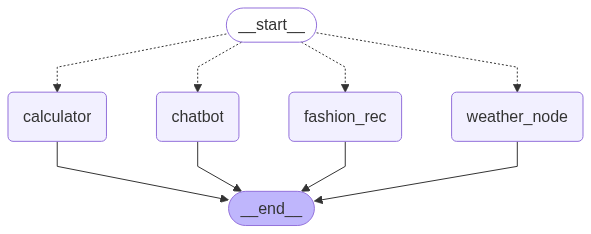

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    
    pass

In [15]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content
                )


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
   
    except KeyboardInterrupt:
        print("\nGoodbye!")
        break

User:  hello


Assistant: Hello! How can I help you today?


User:  whatsup dawg


Assistant: Hey! Just hanging out. What's up with you? Anything exciting happening?


User:  5/3-1+2


Assistant: The result is: 2.666666666666667


User:  weather in new delhi


Assistant: The current weather in new delhi is mist with a temperature of 28.09°C (feels like 32.81°C). Humidity is 83%.


User:  whats trending in new delhi


Assistant: Okay, here's a breakdown of what's trending in fashion in New Delhi right now, based on current observations and reports:

**Overall Trends:**

*   **Comfort and Versatility:** With people spending more time at home and also wanting to transition easily to outings, comfortable and versatile clothing is still key. Think relaxed silhouettes, breathable fabrics, and pieces that can be dressed up or down.
*   **Sustainability and Conscious Consumption:** Eco-friendly fabrics, upcycled clothing, and brands that prioritize ethical production are gaining traction. Consumers are more aware of the environmental impact of their fashion choices.
*   **Fusion Wear:** Blending traditional Indian elements with modern Western styles continues to be popular. This includes kurta dresses, crop tops with sarees, and incorporating Indian prints and embroidery into contemporary designs.
*   **Return of Y2K:** Low-rise jeans, crop tops, baby tees, and vibrant colors are making a comeback.

**Spec